Average IVT of each AR object during El Nino, La Nina, AO+-, SH+-.


## Imports

In [16]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df, mjo_index
from statistical_tests import xr_zscore_diff_mean
from ar_funcs import ar_daily_df

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [5]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_diff']
# plot_dict_ivt = config['ivt_diff']
plot_dict_prec = config['precip_diff']
plot_dict_iwv = config['iwv_diff']
plot_dict_500 = config['lower_diff']

plot_dicts = [plot_dict_upper, plot_dict_500, plot_dict_iwv, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

### AR days and Climate Indices

In [6]:
outpath = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
start_date = '1979-12-01'
end_date = '2019-05-31'

# climate index df
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
df_index = select_months(tele, 12, 5)

df = ar_daily_df(ssn, nk, outpath)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1


In [7]:
idx = (new_df.AR_CAT == 3) 
df = new_df.loc[idx]
df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1980-01-24 09:00:00,0.0,0.0,1.0,1.0,3,-1,0,0,0,-1
1980-02-25 09:00:00,0.0,0.0,1.0,1.0,3,0,1,0,0,0
1980-02-26 09:00:00,0.0,0.0,1.0,1.0,3,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2019-03-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,1,1,-1
2019-03-27 09:00:00,0.0,0.0,1.0,1.0,3,1,0,1,1,-1
2019-03-28 09:00:00,0.0,0.0,1.0,1.0,3,1,0,1,1,-1


In [8]:
filename = 'ar_catalog_v3_ERAI_fraction_HASIAsubregions.nc'
    
f1 = path_to_data + 'CH1_generated_data/' + filename
ds = xr.open_dataset(f1)
# Set dates
ds = ds.sel(time=slice(start_date, end_date))
df2 = ds.to_dataframe()
df2

df2 = df2.resample('1D').mean()

In [9]:
df2

,R01,R01_id,R02,R02_id,R03,R03_id,R04,R04_id,lev,ens
time,,,,,,,,,,
1979-12-01,0.198980,2861.0,0.0,NaN,0.336735,2864.0,0.223416,2864.0,1000.0,1.0
1979-12-02,0.346939,2861.0,0.0,NaN,0.035714,2864.0,0.163462,2864.0,1000.0,1.0
1979-12-03,0.005102,2861.0,0.0,NaN,0.000000,NaN,0.005656,2873.0,1000.0,1.0
1979-12-04,0.000000,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,1000.0,1.0
1979-12-05,0.000000,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,1000.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2019-05-27,0.000000,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,1000.0,1.0
2019-05-28,0.000000,NaN,0.0,NaN,0.000000,NaN,0.000000,NaN,1000.0,1.0
2019-05-29,0.000000,NaN,0.0,NaN,0.000000,NaN,0.010181,128807.0,1000.0,1.0


In [10]:
# stack up 3 subregions id numbers
d = {'r01id': df2['R01_id'],
     'r02id': df2['R02_id'],
     'r03id': df2['R03_id'],
     'r04id': df2['R04_id']}

df_tmp = pd.DataFrame(data=d)

## resample to 1D taking maximum of new column
level_values = df_tmp.index.get_level_values
df_tmp = df_tmp.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=0)]).max()

df_tmp

,,r01id,r02id,r03id,r04id
time,time,,,,
1979-12-01,1979-12-01,2861.0,NaN,2864.0,2864.0
1979-12-02,1979-12-02,2861.0,NaN,2864.0,2864.0
1979-12-03,1979-12-03,2861.0,NaN,NaN,2873.0
1979-12-04,1979-12-04,NaN,NaN,NaN,NaN
1979-12-05,1979-12-05,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-05-27,2019-05-27,NaN,NaN,NaN,NaN
2019-05-28,2019-05-28,NaN,NaN,NaN,NaN
2019-05-29,2019-05-29,NaN,NaN,NaN,128807.0


### AR Catalog

In [37]:
# start-end dates
start_date = '1979-12-01 0:00'
end_date = '2019-05-31 18:00'

# Select lat/lon grid
lonmin = 0.
lonmax = 120
latmin = 0
latmax = 60

filename =  '/home/sbarc/students/nash/data/ar_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ds = xr.open_dataset(filename, engine='netcdf4')
ds = ds.squeeze()
da = ds.kidmap
# subset data
da = da.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
da = da.resample(time='1D').mean()
da

<xarray.DataArray 'kidmap' (time: 14427, lat: 41, lon: 81)>
array([[[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        ...,
        [  2850.,   2850.,   2850., ...,   2861.,   2861.,     nan],
        [  2850.,   2850.,   2850., ...,   2861.,   2861.,     nan],
        [  2850.,   2850.,   2850., ...,   2861.,     nan,     nan]],

       [[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        ...,
        [  2850.,   2850.,   2850., ...,     nan,     nan,     nan],
        [  2850.,   2850.,   2850., ...,   2861.,   2861.,   2861.],
        [  2850.,   2850.,   2850., ...,   2861.,   2861.,   2861.]],

       [[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        ...,
...
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        ...,
        [128776., 128776., 128776., ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        ...,
        [128776., 128776., 128776., ...,     nan,     nan,     nan],
        [128776., 128776., 128776., ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2019-05-31
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 114.0 115.5 117.0 118.5 120.0
  * lat      (lat) float64 0.0 1.5 3.0 4.5 6.0 7.5 ... 54.0 55.5 57.0 58.5 60.0
    lev      float64 1e+03
    ens      float64 1.0

In [39]:
fname = path_to_data + 'ERA5/ivt/anomalies/daily_filtered_anomalies_*.nc'

rename_dict = {'p71.162': 'ivte', 
               'p72.162': 'ivtn', 
               'latitude': 'lat',
               'longitude': 'lon'}

def preprocess(ds):
    '''rename vars'''
    subset = ds.rename(rename_dict)

    return subset

# open data  
dask.config.set(**{'array.slicing.split_large_chunks': False})
ds = xr.open_mfdataset(fname, preprocess=preprocess, combine='by_coords')

ivt_mag = np.sqrt(ds.ivte**2 + ds.ivtn**2)
ds = ds.assign(ivt=ivt_mag) # assign ivt

# regrid to 1.5 x 0.5 degree
ds= ds.interp(lon=da.lon, lat=da.lat)
# subset data
ds = ds.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds

ds size in GB 1.15



<xarray.Dataset>
Dimensions:    (lat: 41, lon: 81, time: 14427)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-05-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(31,), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 115.5 117.0 118.5 120.0
  * lat        (lat) float64 0.0 1.5 3.0 4.5 6.0 ... 54.0 55.5 57.0 58.5 60.0
    lev        float64 1e+03
    ens        float64 1.0
Data variables:
    ivtn       (time, lat, lon) float64 dask.array<chunksize=(31, 41, 81), meta=np.ndarray>
    ivte       (time, lat, lon) float64 dask.array<chunksize=(31, 41, 81), meta=np.ndarray>
    ivt        (time, lat, lon) float64 dask.array<chunksize=(31, 41, 81), meta=np.ndarray>

In [46]:
%%time
ds = ds.assign(kidmap=(['time', 'lat', 'lon'], da.values))
ds.load()

CPU times: user 1min 1s, sys: 39.8 s, total: 1min 41s
Wall time: 16.9 s


<xarray.Dataset>
Dimensions:    (lat: 41, lon: 81, time: 14427)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-05-31T09:00:00
    dayofyear  (time) int64 335 336 337 338 339 340 ... 146 147 148 149 150 151
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 115.5 117.0 118.5 120.0
  * lat        (lat) float64 0.0 1.5 3.0 4.5 6.0 ... 54.0 55.5 57.0 58.5 60.0
    lev        float64 1e+03
    ens        float64 1.0
Data variables:
    ivtn       (time, lat, lon) float64 45.13 38.38 22.21 ... -34.6 -43.5 -59.75
    ivte       (time, lat, lon) float64 32.95 50.79 69.62 ... -45.1 -41.64
    ivt        (time, lat, lon) float64 55.88 63.66 73.07 ... 59.81 62.66 72.83
    kidmap     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [54]:
# average IVT using AR mask
ivt_mask = ds.ivt.where(ds.kidmap > 0).mean(['lat', 'lon'])
# ivt_mask = ivt_mask.resample(time="1D").mean('time')
# Select months
idx = (ivt_mask.time.dt.month >= 12) | (ivt_mask.time.dt.month <= 5)
ivt_mask = ivt_mask.sel(time=idx)

new_df['ivt'] = ivt_mask.values

idx = (new_df.AR_CAT > 0) 
plot_df = new_df.loc[idx]
plot_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO,ivt
date,,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1,118.984601
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1,121.362237
1980-01-24 09:00:00,0.0,0.0,1.0,1.0,3,-1,0,0,0,-1,142.266588
1980-02-12 09:00:00,0.0,1.0,0.0,1.0,2,-1,1,0,0,-1,133.057320
1980-02-13 09:00:00,1.0,0.0,0.0,1.0,1,-1,1,0,0,-1,103.399695
...,...,...,...,...,...,...,...,...,...,...,...
2019-04-09 09:00:00,0.0,1.0,0.0,1.0,2,-1,0,1,1,1,120.901439
2019-04-15 09:00:00,0.0,1.0,0.0,1.0,2,0,0,1,1,1,124.817615
2019-04-16 09:00:00,1.0,0.0,0.0,1.0,1,0,0,1,1,1,121.089893


/home/nash/DATA/repositories/AR_types/figs/boxplot.png


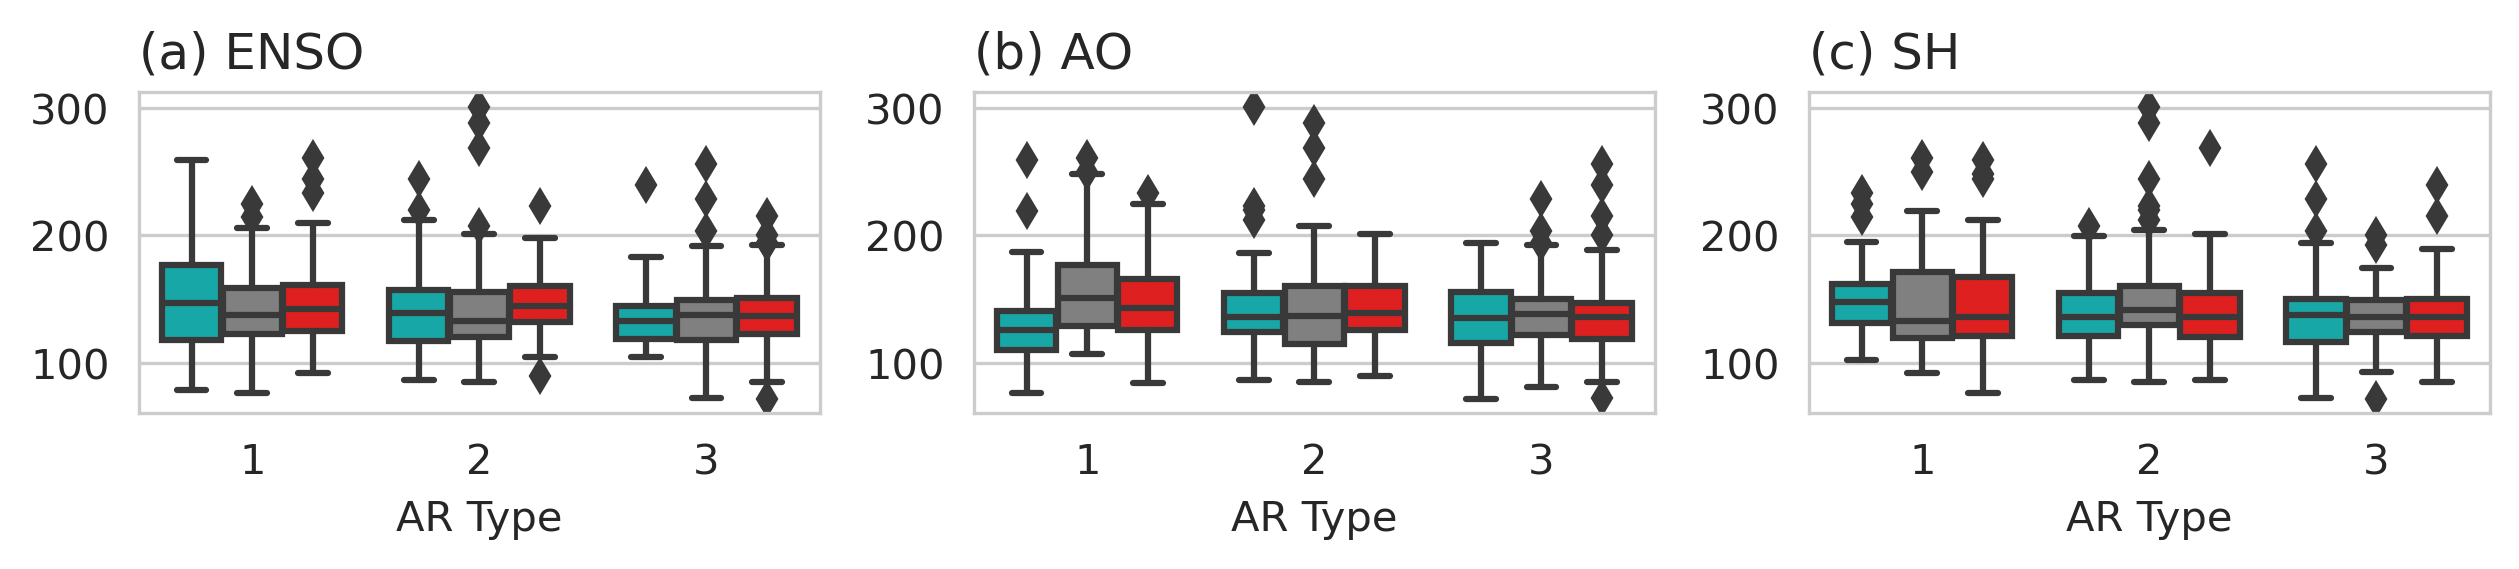

<Figure size 2550x600 with 0 Axes>

In [55]:
fname = path_to_figs + 'boxplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,2.0))
fig.dpi = 300
nrows = 1
ncols = 3
nplots=nrows*ncols

plt_lbl = ['(a) ENSO', '(b) AO', '(c) SH']
cli_lst = ['ENSO', 'AO', 'SH']
flatui = ['c', 'grey', 'red', ]
sns.set_style("whitegrid")


for i, cli in enumerate(cli_lst):
    sns.set_style("whitegrid")
    data = plot_df
    ax = plt.subplot(nrows, ncols, i+1)

    g = sns.boxplot(x="AR_CAT", y="ivt", hue=cli, data=data, palette=flatui)
    
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel('')
    ax.set_xlabel('AR Type')
#     plt.ylim(50, 150)
    ax.set_title(plt_lbl[i], loc='left')

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, labels=['Negative', 'Neutral', 'Positive'], title='Phase')
    

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [56]:
# average IVT using AR mask
ivt_mask = ds.ivt.mean(['lat', 'lon'])
# ivt_mask = ivt_mask.resample(time="1D").mean('time')
# Select months
idx = (ivt_mask.time.dt.month >= 12) | (ivt_mask.time.dt.month <= 5)
ivt_mask = ivt_mask.sel(time=idx)

new_df['ivt'] = ivt_mask.values

idx = (new_df.AR_CAT > 0) 
plot_df = new_df.loc[idx]
plot_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO,ivt
date,,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1,85.744980
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1,75.950645
1980-01-24 09:00:00,0.0,0.0,1.0,1.0,3,-1,0,0,0,-1,61.644768
1980-02-12 09:00:00,0.0,1.0,0.0,1.0,2,-1,1,0,0,-1,58.877735
1980-02-13 09:00:00,1.0,0.0,0.0,1.0,1,-1,1,0,0,-1,56.218184
...,...,...,...,...,...,...,...,...,...,...,...
2019-04-09 09:00:00,0.0,1.0,0.0,1.0,2,-1,0,1,1,1,67.129599
2019-04-15 09:00:00,0.0,1.0,0.0,1.0,2,0,0,1,1,1,74.753511
2019-04-16 09:00:00,1.0,0.0,0.0,1.0,1,0,0,1,1,1,75.356022


/home/nash/DATA/repositories/AR_types/figs/boxplot2.png


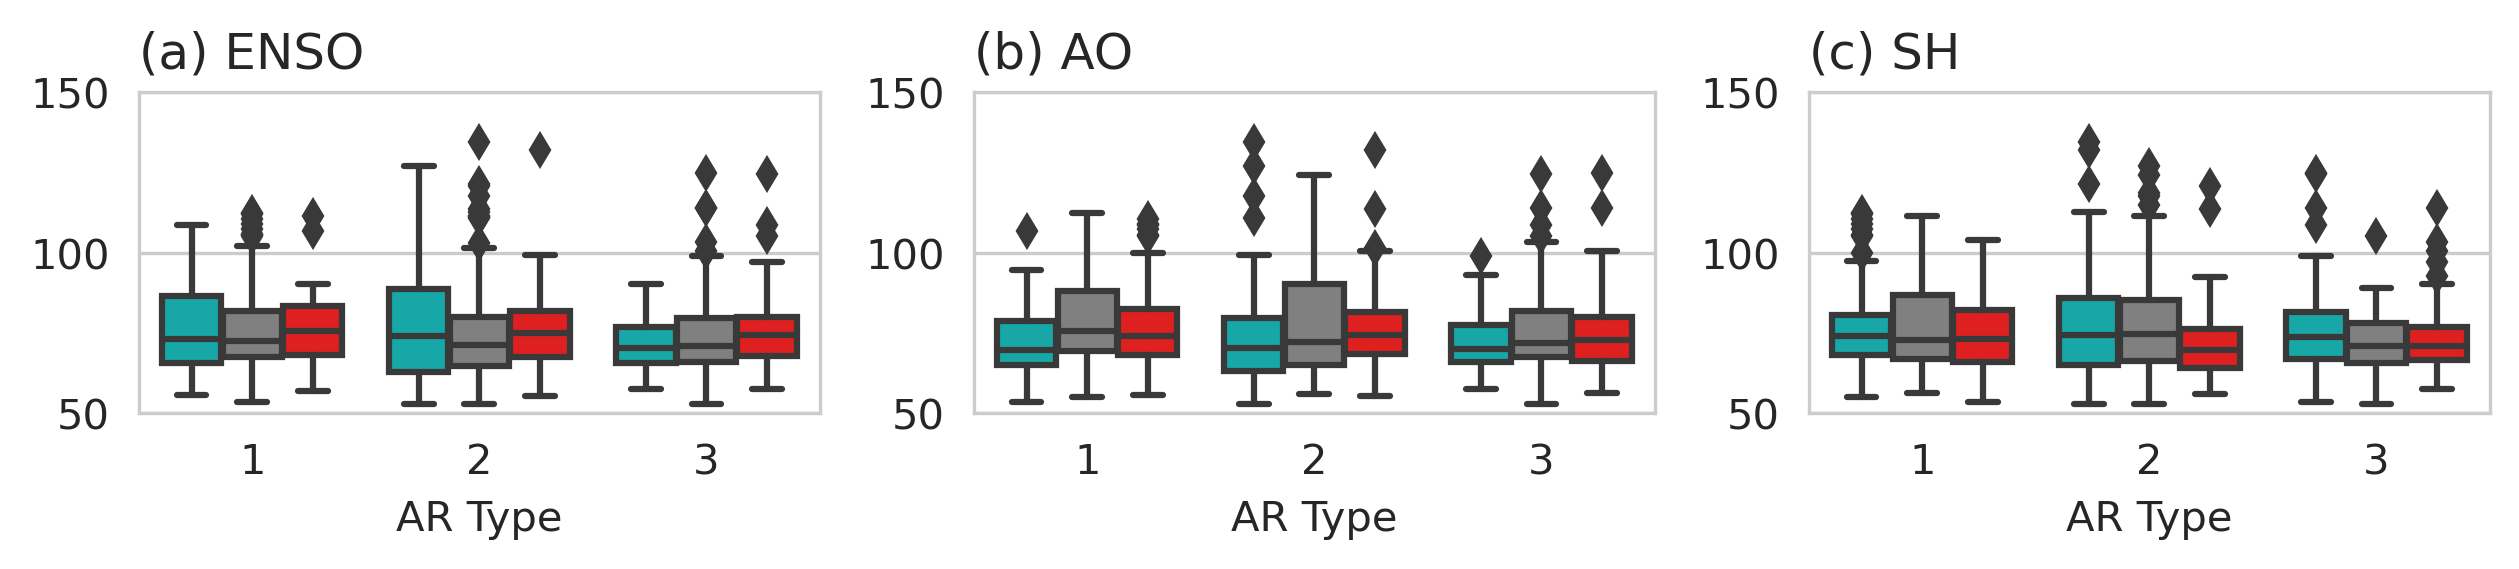

<Figure size 2550x600 with 0 Axes>

In [57]:
fname = path_to_figs + 'boxplot2'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,2.0))
fig.dpi = 300
nrows = 1
ncols = 3
nplots=nrows*ncols

plt_lbl = ['(a) ENSO', '(b) AO', '(c) SH']
cli_lst = ['ENSO', 'AO', 'SH']
flatui = ['c', 'grey', 'red', ]
sns.set_style("whitegrid")


for i, cli in enumerate(cli_lst):
    sns.set_style("whitegrid")
    data = plot_df
    ax = plt.subplot(nrows, ncols, i+1)

    g = sns.boxplot(x="AR_CAT", y="ivt", hue=cli, data=data, palette=flatui)
    
    g.legend_.remove()
    sns.set_style("ticks")
    ax.set_ylabel('')
    ax.set_xlabel('AR Type')
    plt.ylim(50, 150)
    ax.set_title(plt_lbl[i], loc='left')

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, labels=['Negative', 'Neutral', 'Positive'], title='Phase')
    

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [38]:
%%time
date_lst = new_df.index.strftime('%Y-%m-%d').values # list of days no time
final_lst = []
dates = []
ivt_lst = []
for i, ids in enumerate(date_lst):
    print(ids)
    # pull track ID list for each time step
    x = ds.kidmap.sel(time=ids, lat=slice(20, 40), lon=slice(65,95)).values.flatten()
    result = x[np.logical_not(np.isnan(x))]
    trackID = list(set(result.tolist()))
    final_lst.append(trackID)
    
    ivt_vals = []
    for j, tID in enumerate(trackID):
        dates.append(ids)
        ivt_mask = ds.sel(time=ids) # select the time step
        # get the mean IVT value for each trackID at that time step
        ivt_mean = ivt_mask.ivt.where(ivt_mask.kidmap == tID).mean().values
        ivt_vals.append(ivt_mean)
        print(tID, ivt_mean)
        
    ivt_lst.append(ivt_vals)


1979-12-01
2864.0 206.94713346750143
2861.0 196.65864262202666
1979-12-02
2864.0 224.0378666316531
2861.0 180.73940928248007
1979-12-03
2861.0 163.7110912690913
1979-12-04
1979-12-05
1979-12-06
1979-12-07
2918.0 182.1327133178711
2871.0 192.507827328791
1979-12-08
2871.0 203.67061358480274
1979-12-09
2871.0 187.18787240396
1979-12-10
1979-12-11
1979-12-12
1979-12-13
1979-12-14
1979-12-15
1979-12-16
2975.0 197.3335826510475
1979-12-17
2978.0 205.19681390339898
2975.0 165.84328317642212
1979-12-18
1979-12-19
1979-12-20
1979-12-21
2988.0 206.05872796571353
1979-12-22
2988.0 171.56244354839473
1979-12-23
1979-12-24
3033.0 181.49850489729542
3026.0 162.8522604306539
1979-12-25
3033.0 169.79117400691194
1979-12-26
1979-12-27
3038.0 192.17491551779915
1979-12-28
3038.0 204.39164712294092
1979-12-29
1979-12-30
3065.0 310.4260839892972
1979-12-31
1980-01-01
1980-01-02
3096.0 207.61795043945312
1980-01-03
1980-01-04
1980-01-05
1980-01-06
1980-01-07
3137.0 165.8220231817403
1980-01-08
3137.0 155.

1981-04-21
1981-04-22
1981-04-23
1981-04-24
1981-04-25
1981-04-26
1981-04-27
1981-04-28
7205.0 196.014629097872
1981-04-29
7212.0 193.23710826142556
1981-04-30
7223.0 228.6190609512329
1981-05-01
7232.0 247.496808497111
7223.0 262.1939010590127
1981-05-02
7242.0 303.13127437087724
7223.0 274.79367598442184
1981-05-03
7247.0 186.8340345181917
1981-05-04
7258.0 197.88716382758562
1981-05-05
1981-05-06
1981-05-07
1981-05-08
1981-05-09
1981-05-10
1981-05-11
1981-05-12
1981-05-13
1981-05-14
7338.0 191.49683450595498
1981-05-15
1981-05-16
1981-05-17
7338.0 366.51811633639863
1981-05-18
7338.0 299.27001996040343
1981-05-19
1981-05-20
1981-05-21
1981-05-22
7416.0 250.38389258291207
7419.0 220.64725857246214
7389.0 220.68452676379954
1981-05-23
7419.0 185.5463287167433
1981-05-24
7436.0 285.9905268595769
7430.0 172.36195951288397
1981-05-25
7445.0 389.4604149382578
1981-05-26
7445.0 457.1825088311818
1981-05-27
7466.0 100.47617927551269
1981-05-28
7472.0 304.930378419235
1981-05-29
7472.0 412.9

13202.0 229.69292954154636
1983-04-02
13216.0 222.76382871278574
1983-04-03
13216.0 225.99509397660844
1983-04-04
13230.0 265.3716983943598
1983-04-05
13230.0 305.1464048074765
1983-04-06
13230.0 333.1987367493013
1983-04-07
13243.0 260.5688219034982
13239.0 371.6314292971117
1983-04-08
13264.0 385.07887120400704
13262.0 489.7969033090692
1983-04-09
13262.0 512.3789395059858
13266.0 191.4117783485575
13267.0 338.5621966850467
13273.0 351.6876288193923
13275.0 200.44737700474116
1983-04-10
13275.0 248.2960061137959
1983-04-11
13275.0 261.47155929498246
1983-04-12
13275.0 273.78839146973655
1983-04-13
13304.0 383.8534332275391
13309.0 430.3378540039063
1983-04-14
13309.0 369.55592770046655
1983-04-15
13313.0 373.79856643208694
1983-04-16
13313.0 282.815019628678
1983-04-17
1983-04-18
1983-04-19
1983-04-20
1983-04-21
1983-04-22
1983-04-23
1983-04-24
1983-04-25
1983-04-26
1983-04-27
13424.0 353.34839083019057
1983-04-28
13429.0 285.3497004441812
1983-04-29
13439.0 309.72964425304616
1983-0

19028.0 169.08923839515364
1985-02-07
19028.0 172.95448402404784
1985-02-08
1985-02-09
1985-02-10
19061.0 157.01001739501953
1985-02-11
1985-02-12
1985-02-13
1985-02-14
19093.0 332.50188247680666
1985-02-15
19093.0 304.2639357819338
1985-02-16
19093.0 297.9728749593099
1985-02-17
1985-02-18
1985-02-19
1985-02-20
1985-02-21
1985-02-22
19153.0 166.26943883503952
1985-02-23
1985-02-24
1985-02-25
1985-02-26
19170.0 173.06538581331247
1985-02-27
19170.0 153.84649994164184
1985-02-28
1985-03-01
1985-03-02
1985-03-03
19211.0 231.61866075719297
1985-03-04
19211.0 188.74569036940898
1985-03-05
1985-03-06
1985-03-07
19250.0 238.08587081743323
19251.0 264.48476985734976
1985-03-08
19250.0 215.79237234437622
1985-03-09
19271.0 246.17905640602112
1985-03-10
1985-03-11
1985-03-12
1985-03-13
1985-03-14
1985-03-15
1985-03-16
1985-03-17
1985-03-18
1985-03-19
19328.0 235.8572998700823
1985-03-20
19333.0 240.316499431928
19327.0 208.8043738496982
1985-03-21
19327.0 163.08409470938594
1985-03-22
19341.0 2

1986-12-17
24716.0 219.4506042480469
1986-12-18
24733.0 151.60388510567802
1986-12-19
1986-12-20
24738.0 257.35388723642114
1986-12-21
24738.0 196.22576010688235
1986-12-22
1986-12-23
1986-12-24
1986-12-25
1986-12-26
1986-12-27
24795.0 189.13398386963033
1986-12-28
24795.0 192.25478191578642
24811.0 228.3408679837495
1986-12-29
24811.0 292.22364790228346
1986-12-30
24818.0 182.8387408008314
24811.0 276.25698378351
1986-12-31
24827.0 278.0978411793307
24828.0 146.88978441299932
1987-01-01
1987-01-02
1987-01-03
1987-01-04
1987-01-05
1987-01-06
1987-01-07
24873.0 155.00920463330817
1987-01-08
24886.0 193.39982507879083
1987-01-09
1987-01-10
1987-01-11
1987-01-12
1987-01-13
1987-01-14
1987-01-15
1987-01-16
24959.0 228.4596731821696
1987-01-17
24967.0 139.0324725025105
1987-01-18
1987-01-19
1987-01-20
1987-01-21
1987-01-22
1987-01-23
1987-01-24
1987-01-25
1987-01-26
25034.0 153.7271240427253
1987-01-27
25034.0 147.7687245331477
25043.0 220.54666945259527
1987-01-28
25043.0 230.5695518606285

1988-05-09
28891.0 386.5687909186641
1988-05-10
28891.0 381.9658350944519
1988-05-11
28898.0 175.96638246682974
1988-05-12
28907.0 328.64803656216327
1988-05-13
1988-05-14
28913.0 255.9940428766711
1988-05-15
28913.0 205.1865554046631
1988-05-16
1988-05-17
28941.0 364.0812340000283
1988-05-18
28941.0 544.6489271740822
1988-05-19
28941.0 497.54785718917844
1988-05-20
28941.0 396.52773061086793
1988-05-21
28969.0 391.7024670028687
28941.0 509.49303414788045
1988-05-22
28973.0 319.02956362195346
28941.0 553.8706094953749
1988-05-23
28973.0 354.5259588790752
1988-05-24
28973.0 424.7847657055588
1988-05-25
1988-05-26
1988-05-27
1988-05-28
1988-05-29
29048.0 258.6640058936142
1988-05-30
29048.0 246.78080312856497
1988-05-31
29048.0 196.9350705909729
1988-12-01
30769.0 234.51230232868718
1988-12-02
30776.0 215.7833906340119
30769.0 250.2896788681404
1988-12-03
1988-12-04
30769.0 172.6409590544524
1988-12-05
1988-12-06
1988-12-07
1988-12-08
1988-12-09
1988-12-10
1988-12-11
1988-12-12
30840.0 1

34715.0 245.9843658791449
34707.0 197.38340188279938
1990-03-07
34727.0 349.4282729050209
1990-03-08
34742.0 161.78503523201778
1990-03-09
34750.0 160.68324790810638
1990-03-10
1990-03-11
1990-03-12
34773.0 204.91798060773368
34790.0 271.18394129327004
1990-03-13
34800.0 224.12412327733534
34773.0 184.0110824584961
1990-03-14
34800.0 209.4969139099121
1990-03-15
34811.0 227.30403648567884
1990-03-16
1990-03-17
1990-03-18
34828.0 150.34225209554037
34831.0 186.26460094841158
1990-03-19
34833.0 209.26335892654922
1990-03-20
34833.0 218.25399021520846
1990-03-21
34833.0 249.60024326592324
1990-03-22
34833.0 194.08019571690946
34863.0 272.4136034497439
1990-03-23
34863.0 281.86139129684085
1990-03-24
34875.0 228.09411819019016
1990-03-25
34883.0 76.92037063598633
34875.0 195.9668187068059
34885.0 182.59632973048997
1990-03-26
1990-03-27
34888.0 332.1155301359913
1990-03-28
34888.0 271.64645867727717
1990-03-29
34921.0 323.2657284823331
1990-03-30
34921.0 341.2390811964013
1990-03-31
34945.

1991-12-09
40246.0 239.93067493011702
1991-12-10
40246.0 203.01966891081437
1991-12-11
40272.0 197.81229723500323
40246.0 211.2253724950305
1991-12-12
40272.0 191.97410362887095
1991-12-13
40272.0 166.76253443788
1991-12-14
40272.0 156.48612837077152
1991-12-15
40272.0 179.49766323839356
1991-12-16
40272.0 156.30389316960384
1991-12-17
40272.0 154.59285374011023
1991-12-18
1991-12-19
1991-12-20
1991-12-21
40353.0 195.81217599304532
1991-12-22
1991-12-23
1991-12-24
40386.0 240.52506506076853
40382.0 259.8915927593525
1991-12-25
40386.0 268.3669994908633
1991-12-26
40386.0 338.0786321998962
1991-12-27
40386.0 372.32656669247774
1991-12-28
1991-12-29
1991-12-30
1991-12-31
1992-01-01
40437.0 179.44973348379136
1992-01-02
40451.0 301.65626378213204
40437.0 220.27613565054807
1992-01-03
40437.0 228.75332290287545
1992-01-04
40437.0 197.59956605354566
1992-01-05
40437.0 198.05613446340686
1992-01-06
40480.0 191.64207114361702
1992-01-07
40480.0 186.85278542097225
1992-01-08
1992-01-09
1992-01

44135.0 228.9341842651367
1993-03-22
44114.0 293.26885769690995
1993-03-23
44152.0 276.4582011049444
44114.0 379.7572977971039
44150.0 206.5016879910737
1993-03-24
44152.0 263.50203956954783
44155.0 304.20920843613885
1993-03-25
44169.0 242.8212665159311
44155.0 359.40684390830125
44167.0 248.63463408371499
1993-03-26
44169.0 245.16846463580927
1993-03-27
44169.0 267.9491418143299
1993-03-28
1993-03-29
1993-03-30
1993-03-31
1993-04-01
1993-04-02
1993-04-03
1993-04-04
1993-04-05
1993-04-06
1993-04-07
1993-04-08
1993-04-09
44271.0 196.83782331443126
1993-04-10
44279.0 189.49387522212794
44271.0 222.1418540804994
1993-04-11
44285.0 220.8422097198723
1993-04-12
44296.0 272.90732451255275
1993-04-13
44296.0 253.03840602768793
1993-04-14
1993-04-15
44311.0 224.29222267803152
1993-04-16
44311.0 221.8582471330414
1993-04-17
44311.0 198.19156576117865
1993-04-18
1993-04-19
1993-04-20
1993-04-21
1993-04-22
1993-04-23
44339.0 211.91772817674084
1993-04-24
44392.0 188.9064259665353
44388.0 204.706

49910.0 222.6304282238133
1995-02-12
49910.0 195.7350368499756
1995-02-13
49945.0 216.21644894388697
1995-02-14
49945.0 204.29722441848443
1995-02-15
49957.0 212.3854189020522
1995-02-16
49969.0 233.82315187676008
49957.0 216.73007881641388
1995-02-17
1995-02-18
1995-02-19
1995-02-20
1995-02-21
1995-02-22
1995-02-23
50021.0 234.47902086046008
1995-02-24
50017.0 260.89277760020474
50021.0 247.80247205617476
1995-02-25
1995-02-26
1995-02-27
1995-02-28
50048.0 242.5953392615685
1995-03-01
50048.0 250.6315706426447
50059.0 224.1075293223063
1995-03-02
50059.0 219.7528839560116
1995-03-03
50059.0 214.15605652475932
1995-03-04
50081.0 308.56668526785717
50059.0 244.03047460797188
1995-03-05
50084.0 302.7294169834682
1995-03-06
50094.0 242.40584099474293
1995-03-07
50094.0 218.5694993392281
1995-03-08
50094.0 246.8312441037025
1995-03-09
50118.0 247.26406060603628
50094.0 276.0612295399541
1995-03-10
50123.0 219.33764566511115
1995-03-11
50132.0 193.02933626589567
1995-03-12
1995-03-13
1995-0

55516.0 268.6535919189453
55527.0 216.2883871327276
1996-12-03
1996-12-04
1996-12-05
1996-12-06
1996-12-07
1996-12-08
55578.0 259.14908098493305
55575.0 257.5956072685046
1996-12-09
1996-12-10
1996-12-11
1996-12-12
1996-12-13
1996-12-14
1996-12-15
1996-12-16
1996-12-17
55634.0 174.32559815856524
55644.0 348.80951662311764
1996-12-18
55634.0 188.9347547205483
55654.0 372.2117329386922
1996-12-19
1996-12-20
1996-12-21
1996-12-22
55685.0 137.0889832118772
1996-12-23
55689.0 176.37491789731112
55693.0 180.4669179138326
1996-12-24
55693.0 198.7797628258759
1996-12-25
55712.0 159.81824829464867
55680.0 207.60406645509659
1996-12-26
55680.0 190.86706952808652
1996-12-27
55680.0 155.4072679855795
1996-12-28
55680.0 186.38716423589082
1996-12-29
55680.0 173.5988070817799
1996-12-30
1996-12-31
1997-01-01
1997-01-02
1997-01-03
1997-01-04
55792.0 161.74989314018924
1997-01-05
1997-01-06
1997-01-07
1997-01-08
1997-01-09
1997-01-10
1997-01-11
1997-01-12
1997-01-13
1997-01-14
55896.0 169.521352044467

59509.0 312.522722554055
1998-03-25
59520.0 211.79556604053664
59509.0 344.59801233115314
1998-03-26
59509.0 375.2619604041219
1998-03-27
59545.0 206.5220481285682
1998-03-28
1998-03-29
59560.0 298.29439338332855
1998-03-30
59560.0 249.7552584946253
59586.0 210.23199415356387
1998-03-31
59592.0 220.65851545593483
59586.0 337.045677210718
1998-04-01
59592.0 199.48460569018724
1998-04-02
59592.0 226.0751895515286
1998-04-03
1998-04-04
59619.0 162.90547518048967
1998-04-05
59624.0 184.09026724605238
1998-04-06
59630.0 212.34342766429393
1998-04-07
59630.0 222.54829940795898
1998-04-08
59651.0 245.3093724334449
1998-04-09
1998-04-10
59661.0 284.0043985094343
1998-04-11
1998-04-12
59676.0 202.0872986240474
1998-04-13
1998-04-14
1998-04-15
59695.0 292.9446040562221
1998-04-16
1998-04-17
1998-04-18
59716.0 209.10764452912088
59717.0 187.41683139586718
1998-04-19
1998-04-20
59736.0 258.54122974026586
59717.0 172.5952367728097
1998-04-21
59747.0 184.6680865406397
59717.0 274.71842491370927
5974

65589.0 319.1261518339231
2000-02-22
65627.0 296.1091523810999
2000-02-23
65637.0 210.12415134205537
65630.0 205.703014532725
65631.0 197.10664749145508
2000-02-24
65627.0 268.9735896717418
2000-02-25
65651.0 253.46444416046143
2000-02-26
65661.0 271.7335670771992
2000-02-27
65661.0 399.4220417542077
2000-02-28
65671.0 204.43813744906723
2000-02-29
2000-03-01
2000-03-02
2000-03-03
2000-03-04
2000-03-05
2000-03-06
2000-03-07
2000-03-08
65759.0 178.27423169877795
2000-03-09
65764.0 213.22730776158775
2000-03-10
2000-03-11
2000-03-12
65796.0 216.85422758622602
2000-03-13
65802.0 218.00344917990944
2000-03-14
65811.0 255.9148027192122
2000-03-15
2000-03-16
2000-03-17
2000-03-18
2000-03-19
2000-03-20
2000-03-21
2000-03-22
2000-03-23
65881.0 165.2263235276745
2000-03-24
65867.0 202.48150755719442
2000-03-25
65867.0 202.46495087175484
2000-03-26
65867.0 216.46962340601536
2000-03-27
65867.0 162.2749785339483
2000-03-28
65914.0 148.812611134847
2000-03-29
65923.0 132.689852305821
65918.0 321.2

71866.0 174.25089700537993
2002-02-21
71869.0 187.71331377131236
2002-02-22
71869.0 193.08037508884675
2002-02-23
2002-02-24
2002-02-25
71913.0 147.94526436988343
71907.0 185.69452624614013
2002-02-26
71913.0 201.05236817178456
71921.0 258.30917650588015
2002-02-27
2002-02-28
71934.0 244.53076171875
2002-03-01
2002-03-02
71951.0 147.143593205346
2002-03-03
71961.0 226.42324234336934
2002-03-04
2002-03-05
2002-03-06
2002-03-07
2002-03-08
2002-03-09
2002-03-10
2002-03-11
2002-03-12
2002-03-13
2002-03-14
72039.0 238.2905708694458
2002-03-15
2002-03-16
72045.0 184.8013853244239
2002-03-17
72045.0 213.27447462697626
2002-03-18
72045.0 155.2284064164033
2002-03-19
2002-03-20
72089.0 235.06178157237352
72097.0 186.4994534885182
72087.0 202.2520907924339
2002-03-21
72087.0 222.2746681624544
2002-03-22
72087.0 211.5237311502105
2002-03-23
72114.0 335.95114934656544
2002-03-24
2002-03-25
72125.0 195.81017581911854
2002-03-26
72146.0 247.33443031311035
2002-03-27
72159.0 254.79748137100884
2002-0

77720.0 194.31450715024246
77747.0 194.02523362850715
2003-12-29
77747.0 186.349660471866
2003-12-30
2003-12-31
2004-01-01
2004-01-02
2004-01-03
2004-01-04
2004-01-05
2004-01-06
2004-01-07
77809.0 222.07221707098498
2004-01-08
77809.0 219.4627544931265
2004-01-09
77809.0 203.3152354808336
2004-01-10
77846.0 189.56776554520064
77854.0 154.52648524580331
2004-01-11
77854.0 159.3429810559308
77846.0 237.08253533885164
2004-01-12
77846.0 233.0629142011915
2004-01-13
77846.0 215.9056193320243
2004-01-14
77846.0 186.95252053919938
2004-01-15
77846.0 177.95334375118782
2004-01-16
77894.0 138.11073132415316
2004-01-17
2004-01-18
2004-01-19
2004-01-20
77935.0 205.3650194533328
2004-01-21
77935.0 185.55819545868906
2004-01-22
77935.0 206.26275341105912
2004-01-23
77935.0 230.06866450058786
2004-01-24
77962.0 184.6911700657436
77935.0 230.4378467359041
2004-01-25
2004-01-26
77974.0 201.19078063964844
2004-01-27
77979.0 215.87905761451833
2004-01-28
2004-01-29
2004-01-30
78012.0 164.62039475213913

81714.0 189.33015372401985
2005-03-18
81729.0 156.0709851511409
2005-03-19
81735.0 242.92791166759673
2005-03-20
81745.0 256.17585861951784
81735.0 248.98484944390708
2005-03-21
81745.0 299.10584112671927
2005-03-22
2005-03-23
81774.0 238.98356439386095
2005-03-24
81776.0 225.72459427701784
81774.0 277.9507967865412
2005-03-25
81776.0 217.5997569665096
81786.0 189.8230225816905
81774.0 329.7241682499013
2005-03-26
81776.0 235.49778140870865
2005-03-27
81776.0 295.2612019726354
2005-03-28
81808.0 254.7050415944245
2005-03-29
81808.0 265.5813288370768
81817.0 209.52435806819372
2005-03-30
81823.0 270.3724736838505
2005-03-31
81823.0 220.90469896340673
2005-04-01
2005-04-02
2005-04-03
81841.0 225.90526955149997
2005-04-04
81841.0 169.62827847372782
2005-04-05
81841.0 171.57609490914777
2005-04-06
81873.0 77.08381241559982
81878.0 103.3345910240622
2005-04-07
81888.0 57.34886470917733
2005-04-08
2005-04-09
81898.0 86.53636584074602
81900.0 248.90518312676008
2005-04-10
81900.0 231.02993865

88266.0 235.46883731589787
2007-03-17
88266.0 226.31567850247237
2007-03-18
88266.0 256.3047800634661
2007-03-19
88266.0 276.63760847794384
2007-03-20
88266.0 266.46122964420675
2007-03-21
2007-03-22
2007-03-23
2007-03-24
2007-03-25
88295.0 215.3963306825169
2007-03-26
88295.0 220.5634951457441
2007-03-27
88295.0 210.34789772111068
2007-03-28
88295.0 196.32357256775924
2007-03-29
88295.0 178.0511527087053
2007-03-30
88295.0 214.3754706117252
2007-03-31
88388.0 189.09731643459807
88295.0 209.86315379901365
2007-04-01
2007-04-02
2007-04-03
88414.0 233.79348637241355
2007-04-04
88414.0 190.9090716613466
2007-04-05
88428.0 180.30981891773365
2007-04-06
2007-04-07
2007-04-08
88425.0 189.61329613701773
88451.0 276.6974451948957
2007-04-09
2007-04-10
88468.0 168.06189230213994
2007-04-11
2007-04-12
2007-04-13
88467.0 226.19321094682192
2007-04-14
88467.0 239.1747198337462
2007-04-15
88494.0 280.78365388208505
2007-04-16
88507.0 251.90939906519702
2007-04-17
2007-04-18
2007-04-19
2007-04-20
20

94515.0 311.26653947221473
2009-02-22
94518.0 215.7410777451156
2009-02-23
2009-02-24
2009-02-25
94552.0 220.233019211713
94549.0 169.32678177243187
2009-02-26
94555.0 251.09897609165736
94539.0 247.70101490020753
2009-02-27
94564.0 241.49001077036507
2009-02-28
94564.0 231.18587208708985
2009-03-01
94564.0 238.08581533826086
2009-03-02
94564.0 222.09132426680483
2009-03-03
94564.0 177.28576243608848
2009-03-04
2009-03-05
2009-03-06
2009-03-07
2009-03-08
2009-03-09
2009-03-10
94659.0 194.3999408086141
2009-03-11
94665.0 214.2104899982294
94630.0 197.04843151569366
2009-03-12
94665.0 338.4651189994812
94676.0 210.11481522068834
94630.0 215.11122145219284
2009-03-13
2009-03-14
2009-03-15
94692.0 196.36091789535328
2009-03-16
2009-03-17
94730.0 166.0368412562779
2009-03-18
94730.0 165.00040273797023
2009-03-19
2009-03-20
2009-03-21
2009-03-22
94766.0 161.39455679691198
2009-03-23
94774.0 186.13062905729487
2009-03-24
2009-03-25
94765.0 221.7694405938074
2009-03-26
94765.0 234.337730913162

98681.0 75.07110750675201
98679.0 422.0489371149423
2010-05-25
98679.0 378.1772051573516
2010-05-26
98696.0 248.80700471060618
98679.0 354.1000836856702
2010-05-27
2010-05-28
98713.0 238.61402276846079
2010-05-29
2010-05-30
2010-05-31
98686.0 391.3592912753423
2010-12-01
2010-12-02
2010-12-03
100545.0 230.04285366451575
2010-12-04
2010-12-05
100604.0 221.64582116263253
2010-12-06
100617.0 233.27859897613524
2010-12-07
100616.0 465.5082995195797
2010-12-08
100619.0 378.81390711330477
2010-12-09
100619.0 374.13603430467026
2010-12-10
100619.0 362.92741948512014
2010-12-11
100619.0 362.19588975808057
2010-12-12
100619.0 393.8234648810493
2010-12-13
2010-12-14
2010-12-15
2010-12-16
2010-12-17
2010-12-18
2010-12-19
2010-12-20
2010-12-21
2010-12-22
2010-12-23
2010-12-24
2010-12-25
2010-12-26
2010-12-27
2010-12-28
2010-12-29
100790.0 274.2817536989848
2010-12-30
100806.0 168.62478516522575
2010-12-31
100821.0 152.2045382824573
2011-01-01
100821.0 158.94093899668
2011-01-02
2011-01-03
2011-01-

105042.0 255.34276172571015
2012-04-21
2012-04-22
105067.0 239.78085897440897
2012-04-23
105067.0 321.04557299464005
2012-04-24
105067.0 469.34504788402666
2012-04-25
2012-04-26
105096.0 315.16351114908855
2012-04-27
105103.0 336.7437228484301
2012-04-28
105103.0 410.2255108933577
2012-04-29
105113.0 192.04394087150916
105103.0 460.3860591734895
2012-04-30
105103.0 444.02333364726496
2012-05-01
105129.0 123.50920734405517
2012-05-02
105125.0 253.43179394308208
2012-05-03
2012-05-04
2012-05-05
2012-05-06
105165.0 159.58610708063298
2012-05-07
2012-05-08
2012-05-09
2012-05-10
2012-05-11
2012-05-12
2012-05-13
2012-05-14
2012-05-15
2012-05-16
2012-05-17
2012-05-18
2012-05-19
2012-05-20
2012-05-21
2012-05-22
2012-05-23
2012-05-24
105304.0 202.21021406991142
2012-05-25
2012-05-26
2012-05-27
2012-05-28
105337.0 166.6937840975248
2012-05-29
2012-05-30
2012-05-31
2012-12-01
2012-12-02
2012-12-03
2012-12-04
2012-12-05
2012-12-06
107212.0 187.05352184881312
2012-12-07
2012-12-08
2012-12-09
2012-1

111449.0 216.3445668663777
2014-03-20
2014-03-21
2014-03-22
111473.0 248.43399573734828
2014-03-23
111473.0 214.2328095917308
2014-03-24
2014-03-25
111502.0 185.05046559893896
2014-03-26
111502.0 232.72702306305047
2014-03-27
111502.0 239.2767677203843
2014-03-28
2014-03-29
111536.0 176.03767155062766
111525.0 199.23849338198465
2014-03-30
2014-03-31
111525.0 229.53400045837287
2014-04-01
111562.0 206.9499378647915
111525.0 263.7960033129208
2014-04-02
2014-04-03
111560.0 220.86375881815493
2014-04-04
111560.0 210.38745074134485
2014-04-05
111560.0 196.9791941466155
111611.0 216.7709395272391
2014-04-06
2014-04-07
111621.0 228.1096590199048
2014-04-08
2014-04-09
111634.0 202.58972107592245
2014-04-10
111634.0 222.84716115386072
2014-04-11
111670.0 169.64856119155883
2014-04-12
2014-04-13
2014-04-14
2014-04-15
111691.0 176.32501484264026
2014-04-16
2014-04-17
2014-04-18
2014-04-19
111739.0 67.9483714507798
2014-04-20
111750.0 97.50870767320906
2014-04-21
2014-04-22
2014-04-23
2014-04-24

2016-01-09
117531.0 188.6781409937948
2016-01-10
117531.0 166.6656005324949
2016-01-11
117531.0 180.2141521693063
2016-01-12
2016-01-13
2016-01-14
2016-01-15
2016-01-16
2016-01-17
2016-01-18
117690.0 199.11407708062066
2016-01-19
117690.0 245.9932620796615
2016-01-20
117690.0 266.7594196521822
2016-01-21
117690.0 326.04380874909714
2016-01-22
117690.0 368.0129806478188
2016-01-23
2016-01-24
2016-01-25
117731.0 199.34484640856894
2016-01-26
117750.0 219.57627277583867
2016-01-27
117760.0 217.12202591798743
2016-01-28
117760.0 242.0617657283066
2016-01-29
117760.0 248.29142324040444
2016-01-30
2016-01-31
2016-02-01
2016-02-02
2016-02-03
2016-02-04
2016-02-05
2016-02-06
2016-02-07
117844.0 193.69861914894798
2016-02-08
2016-02-09
2016-02-10
2016-02-11
2016-02-12
117879.0 254.53622134056317
117887.0 230.25352668762207
2016-02-13
2016-02-14
2016-02-15
2016-02-16
2016-02-17
117924.0 215.46131562650874
2016-02-18
117924.0 266.4588433970576
2016-02-19
117938.0 279.02220216741415
2016-02-20
117

121828.0 182.7138677556464
2017-04-07
2017-04-08
121859.0 140.10828013752783
2017-04-09
2017-04-10
121866.0 193.24540568908415
2017-04-11
121866.0 200.69498553420559
2017-04-12
2017-04-13
2017-04-14
2017-04-15
2017-04-16
121921.0 492.836134817086
2017-04-17
2017-04-18
121924.0 205.71899930395261
2017-04-19
2017-04-20
2017-04-21
121965.0 105.90869689941407
2017-04-22
2017-04-23
121985.0 340.60489785330634
2017-04-24
121985.0 306.85517186164856
2017-04-25
122000.0 272.69519830703734
2017-04-26
2017-04-27
2017-04-28
2017-04-29
2017-04-30
2017-05-01
2017-05-02
122049.0 229.69716889003539
2017-05-03
2017-05-04
2017-05-05
122069.0 207.80794123983293
2017-05-06
122069.0 239.37130002546616
2017-05-07
122069.0 218.6080547885824
122087.0 188.39024510920441
2017-05-08
2017-05-09
122091.0 254.90489522148582
2017-05-10
2017-05-11
2017-05-12
2017-05-13
122135.0 103.77394650777181
2017-05-14
2017-05-15
2017-05-16
2017-05-17
2017-05-18
2017-05-19
2017-05-20
2017-05-21
2017-05-22
122204.0 293.240259121

128050.0 248.72034259552652
128055.0 224.42435464979727
2019-02-27
128055.0 216.40450720306313
2019-02-28
128064.0 249.63258849657498
128066.0 163.8589467304509
128055.0 234.06274838639487
2019-03-01
128064.0 254.0370071742426
2019-03-02
128064.0 293.92617825305825
2019-03-03
2019-03-04
128101.0 166.84666490785165
2019-03-05
128111.0 263.08417640279987
2019-03-06
128111.0 315.33570579102803
2019-03-07
128111.0 256.95591735839844
2019-03-08
128127.0 339.39049185475994
2019-03-09
2019-03-10
2019-03-11
128145.0 184.11999905260302
128149.0 210.4118429044398
2019-03-12
2019-03-13
128162.0 248.84204154179014
2019-03-14
128172.0 229.8979162488665
2019-03-15
128177.0 185.86084054262582
2019-03-16
128189.0 210.7135866800944
2019-03-17
128199.0 262.09900303741
2019-03-18
128216.0 194.89812683640864
2019-03-19
128216.0 328.1677648665139
2019-03-20
2019-03-21
2019-03-22
128233.0 194.13139026681174
2019-03-23
128233.0 219.04174166992493
2019-03-24
128233.0 216.40400052210043
128243.0 223.6654806529

In [42]:
ivt_lst[0]

[array(206.94713347), array(196.65864262)]

In [34]:
ids = 1
ivt_mask = ds.ivt.isel(time=ids).where(ds.kidmap > 0)

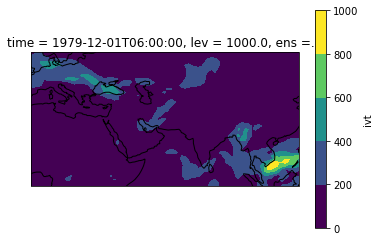

In [35]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds.ivt.isel(time=ids).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

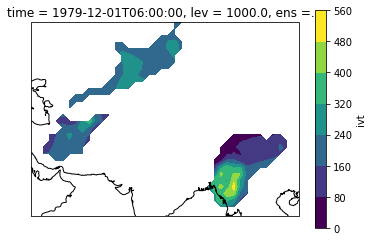

In [36]:
ax = plt.axes(projection=ccrs.PlateCarree())
ivt_mask.isel(time=ids).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

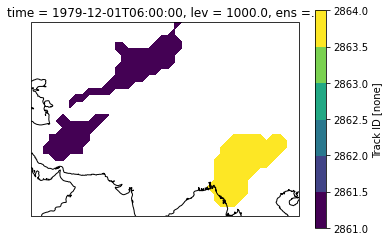

In [37]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds.kidmap.isel(time=ids).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()